In [41]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (roc_auc_score, average_precision_score,
                           roc_curve, precision_recall_curve,
                           confusion_matrix, classification_report)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
import anndata as ad
ppmi_ad = ad.read_h5ad("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/ppmi_adata.h5ad")

In [43]:
import pandas as pd
consensus_genes = pd.read_csv("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/feature_selection_consensus_males_30-50.csv", index_col=0)

In [44]:
mask = ((ppmi_ad.obs['Age_Group'] == '30-50') &
        (ppmi_ad.obs['Gender'] == 'Male') &
        (ppmi_ad.obs['Diagnosis'].isin(['PD', 'Control'])) &
        (ppmi_ad.obs['Visit'] == 'BL'))

In [45]:
ppmi_ad = ppmi_ad[mask]

In [46]:
ppmi_ad = ppmi_ad[:, ppmi_ad.var.index.isin(consensus_genes.index)]

In [47]:
X = pd.DataFrame(ppmi_ad.layers['counts_log2'], columns=ppmi_ad.var_names)
y = (ppmi_ad.obs['Diagnosis'] == 'PD').astype(int)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [49]:
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 'auto', 0.1],
    'svm__kernel': ['linear', 'rbf'],
    'smote__k_neighbors': [3, 5]
}

In [50]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('svm', SVC(probability=True, random_state=42))
])

In [51]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=svm_pipeline, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
best_svm = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'smote__k_neighbors': 3, 'svm__C': 0.1, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}


In [52]:
y_pred = best_svm.predict(X_test)
y_proba = best_svm.predict_proba(X_test)[:,1]

In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.71      0.83      0.77         6

    accuracy                           0.70        10
   macro avg       0.69      0.67      0.67        10
weighted avg       0.70      0.70      0.69        10



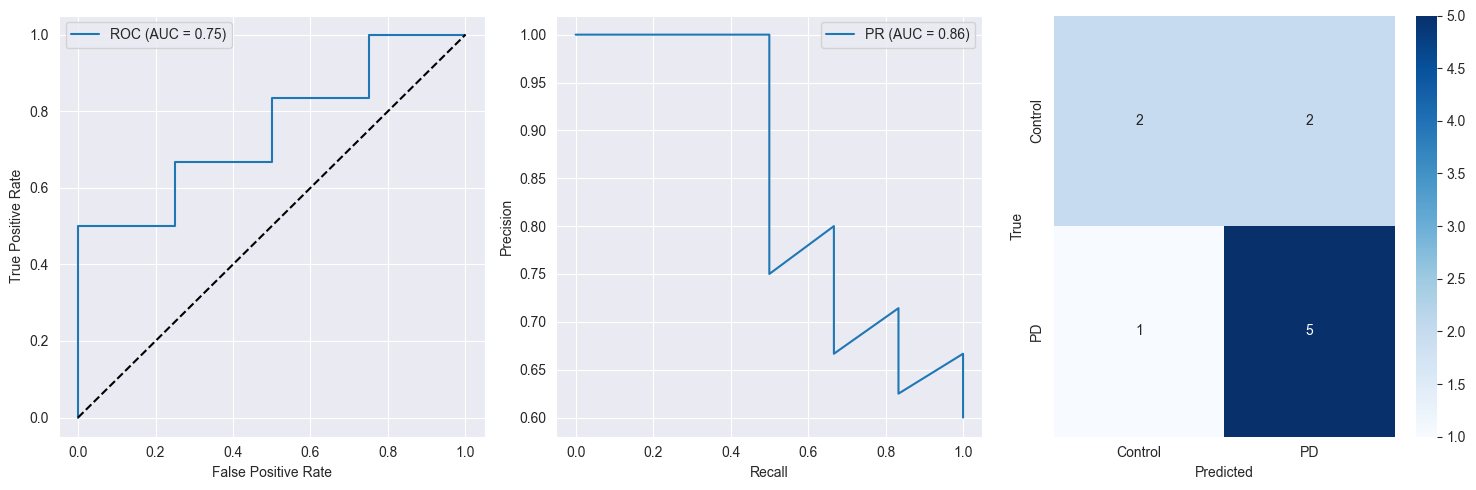

In [54]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.subplot(1, 3, 2)
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision, label=f'PR (AUC = {average_precision_score(y_test, y_proba):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 3, 3)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Control', 'PD'],
            yticklabels=['Control', 'PD'])
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

In [55]:
import numpy as np
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = {'roc_auc': [], 'pr_auc': []}

for train_idx, val_idx in cv.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    svm_pipeline.fit(X_train, y_train)
    y_proba = svm_pipeline.predict_proba(X_val)[:, 1]

    cv_scores['roc_auc'].append(roc_auc_score(y_val, y_proba))
    cv_scores['pr_auc'].append(average_precision_score(y_val, y_proba))

print("\nCross-validation results:")
print(f"ROC-AUC: {np.mean(cv_scores['roc_auc']):.3f} ± {np.std(cv_scores['roc_auc']):.3f}")
print(f"PR-AUC: {np.mean(cv_scores['pr_auc']):.3f} ± {np.std(cv_scores['pr_auc']):.3f}")



Cross-validation results:
ROC-AUC: 0.851 ± 0.077
PR-AUC: 0.914 ± 0.046
